In [44]:
import numpy as np
import peakutils
import syntheticdata

import threegaussians

from peakutils.plot import plot as pplot
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
from scipy import interpolate

import pandas as pd
from pyearth import Earth

In [2]:
# load some data
def loaddata(data_filename):
    """load matrix data"""
    data = np.genfromtxt(data_filename, delimiter='\t')
    data_nm = data[1:,0]    #wavelength in nm
    data_time = data[0,1:]
    data_z = data[1:, 1:]

    return data_nm, data_time, data_z

In [3]:
# add noise
def add_noise(nm_array, y_array, noise_coefficient):
    # Add noise
    np.random.seed(1800)
    y_noise = noise_coefficient * np.random.normal(size=nm_array.size)
    y_proc = y_array + y_noise
    
    return y_proc

In [4]:
def Earth_Smoothing(nm_array, y_array,noise_coefficient):        
    """
    ============================================
     Plotting derivatives of simple sine function
    ============================================

     A simple example plotting a fit of the sine function
    and the derivatives computed by Earth.
    
    Notes
    -----   
    generates a denoise curve from the TA data
    Parameters
    ----------
        nm_array: wavelength array
        timedelay: time delay array
        noise_coefficient: the noise coefficients that user want to generate
    Returns
    -------
        a smoothing curve from the original noise curve   
    """
    
   # Fit an Earth model
    model = Earth(smooth=True)
    np.random.seed(42)
    ydata = y_array + noise_coefficient*np.random.normal(size=nm_array.size)
    model.fit(nm_array, ydata)

   # Print the model
    #print(model.trace())
    #print(model.summary())

   # Get the predicted values and derivatives
    y_hat = model.predict(nm_array)
    
    return  y_hat

In [5]:
def earth_smooth_matrix(nm_array,data_matrix,noise_coefficient):
    num_array = np.shape(data_matrix)[0]
    
    smooth_matx = pd.DataFrame(np.empty((num_array,1)), columns = ['a'])
    noise_matx = pd.DataFrame(np.empty((num_array,1)), columns = ['a'])
    
    for i in range(num_array):
        data_array = data_matrix[:, i]
        
        # get noise and smooth list
        noise_array = add_noise(nm_array, data_array, noise_coefficient).tolist()
        smooth_array =earth_Smoothing(nm_array,data_array,noise_coefficient).tolist()
        
        # get noise dataframe
        DF = pd.DataFrame(noise_array,columns = [i])
        noise_matx = noise_matx.join(DF)
        
        # get smooth dataframe
        df = pd.DataFrame(smooth_array,columns = [i])
        smooth_matx = smooth_matx.join(df)
        
    # drop the first columns  
    noise_matx = noise_matx.drop(columns='a')
    smooth_matx = smooth_matx.drop(columns='a')
        
    return noise_matx, smooth_matx

In [6]:
def findpeak(data_z_array, threshold, min_dist):
    """find peaks and return indices of the peaks"""    
    peak_indices = peakutils.indexes(data_z_array, thres=threshold, min_dist=min_dist)
    
    return peak_indices

In [7]:
def earth_peak_matrix(nm_array,data_matrix,noise_coefficient,threshold, min_dist):
    num_array = np.shape(data_matrix)[1]
    
    true_peak = []
    smooth_peak = []
    
    for i in range(num_array):
        data_array = data_matrix[:, i]
        noise_array = add_noise(nm_array, data_array, noise_coefficient)
        smooth_array = Earth_Smoothing(nm_array, data_array,noise_coefficient)
        
        indexes=findpeak(data_array, threshold, min_dist).tolist()
        true_peak.append(indexes)
        
        indexes1=findpeak(smooth_array, threshold, min_dist).tolist()
        smooth_peak.append(indexes1)
                
        # transfer to dataframe
        true_df=pd.DataFrame(true_peak)
        smooth_df=pd.DataFrame(smooth_peak)
    
    return true_df, smooth_df

# Use py-earth to smoothen data and peakutils to find peaks #

In [8]:
matx_filename = '20180418_twogaussian_spectralshfit.txt'
datanm, datatime, dataz_matx = loaddata(matx_filename)
## get the peak position dataframe of true data set
true_df, smooth_df = earth_peak_matrix(datanm, dataz_matx, 0.1, 0, 10)

/Users/demiliu/miniconda3/lib/python3.6/site-packages/sklearn_contrib_py_earth-0.1.0-py3.6-macosx-10.7-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/demiliu/miniconda3/lib/python3.6/site-packages/sklearn_contrib_py_earth-0.1.0-py3.6-macosx-10.7-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


In [9]:
true_df

,0,1
0,50,400
1,50,400
2,50,400
3,50,400
4,51,400
5,51,400
6,51,400
7,51,400
8,52,400
9,52,400


In [10]:
smooth_df

,0,1,2
0,50,402.0,NaN
1,53,393.0,NaN
2,54,393.0,NaN
3,54,394.0,NaN
4,53,198.0,392.0
5,55,389.0,NaN
6,55,389.0,NaN
7,54,389.0,NaN
8,54,389.0,NaN
9,55,213.0,389.0


In [72]:
peak_true_matx = np.array(true_df)
peak_smooth_matx = np.array(smooth_df)

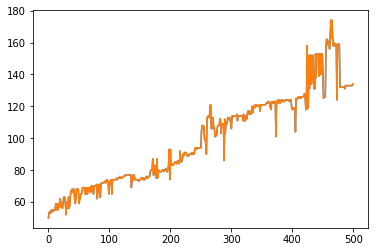

In [211]:
peak_array = peak_smooth_matx[:, 0]
for i in range(1, 500):
    peak = peak_array[i]
    if str(peak_array[i]) == 'nan':
        peak_array[i] = peak_array[i-1]
    else:
        pass

plt.figure()
plt.plot(datatime, peak_smooth_matx[:, 0])
plt.plot(datatime, peak_array)

In [15]:
peak_smooth_matx_corr = np.nan_to_num(peak_smooth_matx)
peak_smooth_matx_corr

array([[ 50., 402.,   0.],
       [ 53., 393.,   0.],
       [ 54., 393.,   0.],
       ...,
       [133.,   0.,   0.],
       [133.,   0.,   0.],
       [134.,   0.,   0.]])

### absolute error ###

In [213]:
def peakpos_error_array(true_pos, pos_output):
    
    error = np.sum((true_pos - pos_output)**2)

    return error

In [215]:
peak1 = peak_smooth_matx_corr[:, 0]
peak1_true = peak_true_matx[:, 0]

error = peakpos_error_array(peak1_true, peak1)

error

32142.0

In [220]:
def peakpos_error_array_rel(true_pos, pos_output, thre):
    error = 0
    diff = np.empty_like(true_pos)
    
    for i in range(len(true_pos)):
        diff[i] = abs(true_pos[i] - pos_output[i])
        if diff[i] >= thre:
            error += (diff/thre)
            
    return diff, error

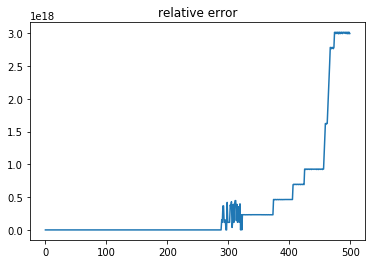

In [225]:
abs_diff, rel_error = peakpos_error_array_rel(peak1_true, peak1, 20)

plt.figure()
plt.title('relative error')
plt.plot(datatime, rel_error)

In [ ]:
def peakpos_error_matrix_bypeak(true_pos, pos_output):
    num_array = np.shape(true_pos)[0]
    error_matx = np.empty_like(true_pos)
    for i in range(num_array):
        error = peakpos_error_array(true_pos[i, :], pos_output[i, :])
        error_matx[i, :] = error
    
    return error_matx

## Try force a continuous 1st and 2nd derivative via spline interpolation ##

In [17]:
from scipy.interpolate import splev, splrep

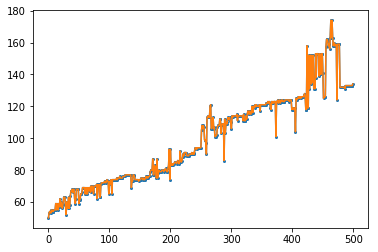

In [155]:
peak_pos_true = peak_true_matx[:, 0]
peak_pos = peak_smooth_matx_corr[:, 0]
peak_pos_splrep = splrep(datatime, peak_pos)
peak_pos_splev = splev(datatime, peak_pos_splrep)

plt.figure()
plt.plot(datatime, peak_pos, '-o', markersize = 2, label = 'output from peakfinding')
plt.plot(datatime, peak_pos_splev, label = 'spline interpolation')
#plt.plot(datatime, peak_pos_true, '-o', markersize = 2, label = 'true peak position')

### From above, continuous 1st and 2nd derivatives are not good criteria to improve peak-finding ###

### We want to screen *sudden changes* in peak position ###

### To do this, we want to first identify outliers, then fix their values ###
* Method #1: 
    1. define a window size to look at and calculate the average and standard deviation of y
    2. compare the value with the average value within the window
    3. if the difference is greater than m * standard deviation, replace the value with the mean


In [115]:
def remove_outliers(y, window_size, m):
    y_corr = np.copy(y)
    tol_len = len(y)
    start_idx = window_size
    end_idx = tol_len - window_size - 1
    idx_range = np.arange(start_idx, end_idx+1, 1)
    for i in idx_range:
        idx = int(i)
        y_check = y[idx]
        y_neighbor = y[idx-window_size:idx+window_size+2]
        y_mean = np.mean(y_neighbor)
        y_std = np.std(y_neighbor)
        y_diff = (y_check - y_mean) ** 2 
        if y_diff >= m * y_std:
            y_corr[idx] = y_mean
    
    return y_corr

In [190]:
def remove_steps(y, thre):
    y_corr = np.copy(y)
    tol_len = len(y)
    for i in np.arange(1, tol_len):
        idx = int(i)
        y_check = y[idx]
        y_before = y[idx-1]

        y_diff = abs(y_check - y_before)
        if y_diff >= thre:
            y_corr[idx] = y_before
    
    return y_corr

In [198]:
y_rmvoutl = remove_outliers(peak_pos_splev, 30, 1)
y_rmvstep = remove_steps(y_rmvoutl, 1)

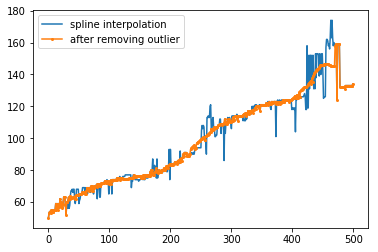

In [201]:
plt.figure()

#plt.plot(datatime, peak_pos, '-o', markersize = 2, label = 'output from peakfinding')

plt.plot(datatime, peak_pos_splev, label = 'spline interpolation')
plt.plot(datatime, y_rmvoutl, '-o', markersize = 2, label = 'after removing outlier')
#plt.plot(datatime, y_rmvstep, '-o', markersize = 2, label = 'after removing step')

plt.legend()

* Method 2:
    1. Divide up the entire array into windows of a defined size
    2. In each window, compare each value with the average value in this window
    3. If the difference is greater than m * standard deviation, **remove** this value
    4. Interpolate the entire array with a spline

In [59]:
def id_outliers_replacewith_interp(x_array, data, m, win_len):
    reshape_x_array = []
    reshape_data = []
    quotient_array = np.empty(len(data))
    remainder_array = np.empty(len(data))
    quotient_array[0] = 0
    remainder_array[0] = 0  
    #print divmod(len(data), win_len)   
    quotient_max = divmod(len(data), win_len)[0]
    print (quotient_max)
    #quotient_array_new = []
    data_idx = np.arange(0, len(data), 1)
    for i in range(1, len(data_idx)):
        
        quotient = divmod(data_idx[i], win_len)[0]
        quotient_array[i] = quotient
        remainder = divmod(data_idx[i], win_len)[1]
        remainder_array[i] = remainder
        
        if quotient != quotient_array[i-1]:
            newslice = data[i - win_len: i]
            newslice_x = x_array[i - win_len: i]
            #print newslice
            reshape_data.append(newslice)
            reshape_x_array.append(newslice_x)
    
        else:
            pass
    quotient_max_idx = np.where(quotient_array == quotient_max)
    #print quotient_max_idx
    reshape_data.append(data[quotient_max_idx[0]])
    reshape_x_array.append(x_array[quotient_max_idx[0]])
    #print reshape_data
    reshape_data_shape = np.shape(reshape_data)[0]
    #print reshape_data_shape
    def id_outliers_and_delete(d,x, m):
        d_mean = np.mean(d)  
        d_stdev = np.std(d)
        new_d = np.empty_like(d)    
        
        for i in range(len(d)):
            d_pt = d[i]
          
            if abs(d_pt - d_mean) > m * d_stdev and x[i] != x_array[0] and x[i] != x_array[len(x_array) - 1]:
                new_d[i] = 1
            else:
                new_d[i] = 0
    
        outlier_idx = np.nonzero(new_d)[0]
        d_delete = np.delete(d, outlier_idx)
        x_delete = np.delete(x, outlier_idx)
        
        #print data2[outlier_idx]
        return x_delete, d_delete
    
    new_x_array = []
    new_data = []
    for i in range(reshape_data_shape):
        new_data.append(id_outliers_and_delete(reshape_data[i],reshape_x_array[i], 1)[1])#(id_outliers_replacewith_mean(reshape_data[i], m))
        new_x_array.append(id_outliers_and_delete(reshape_data[i],reshape_x_array[i],1)[0])
    new_data_flat = np.concatenate(new_data[:-1]).ravel().tolist()#.flatten()
    new_x_array_flat = np.concatenate(new_x_array[:-1]).ravel().tolist()#.flatten()
    new_data_final = np.concatenate((new_data_flat, new_data[reshape_data_shape - 1]))
    new_x_array_final = np.concatenate((new_x_array_flat, new_x_array[reshape_data_shape - 1]))
    
    new_data_final_interp = np.interp(x_array, new_x_array_final, new_data_final)    
    return new_data_final_interp

25


/Users/demiliu/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/demiliu/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/demiliu/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/demiliu/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/demiliu/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


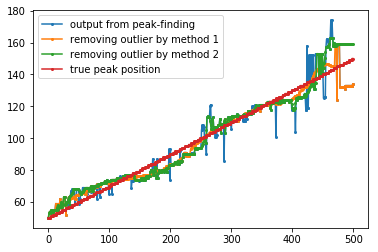

In [202]:
outlier_interp = id_outliers_replacewith_interp(datatime, peak_pos, 1, 20)
plt.figure
plt.plot(datatime, peak_pos, '-o', markersize = 2, label = 'output from peak-finding')
plt.plot(datatime, y_rmvoutl, '-o', markersize = 2, label = 'removing outlier by method 1')
plt.plot(datatime, outlier_interp, '-o', markersize = 2, label = 'removing outlier by method 2')
plt.plot(datatime, peak_pos_true, '-o', markersize = 2, label = 'true peak position')
plt.legend()

### Peak position should never jump around, i.e. monotonously increasing or decreasing ###

### Fit the peak position to an isotonic regression model ##

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
from sklearn import linear_model

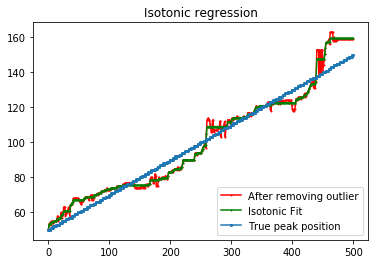

In [210]:
x = datatime
y = outlier_interp

ir = IsotonicRegression()
y_ = ir.fit_transform(x, y)


fig = plt.figure()
plt.plot(x, y, 'r.-', markersize=2)
plt.plot(x, y_, 'g.-', markersize=2)
plt.plot(datatime, peak_pos_true, 'o-', markersize = 2)

plt.legend(('After removing outlier', 'Isotonic Fit', 'True peak position'), loc='lower right')
plt.title('Isotonic regression')
plt.show()

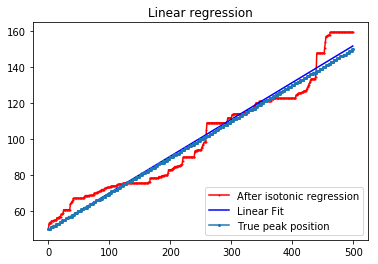

In [208]:
lr = LinearRegression()
lr.fit(x[:, np.newaxis], y_) 

fig = plt.figure()
plt.plot(x, y_, 'r.', markersize=2)

plt.plot(x, lr.predict(x[:, np.newaxis]), 'b-')
plt.plot(datatime, peak_pos_true, '-o', markersize = 2, label = 'true peak position')

plt.legend(('After isotonic regression', 'Linear Fit', 'True peak position'), loc='lower right')
plt.title('Linear regression')
plt.show()

/Users/demiliu/miniconda3/lib/python3.6/site-packages/sklearn_contrib_py_earth-0.1.0-py3.6-macosx-10.7-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/demiliu/miniconda3/lib/python3.6/site-packages/sklearn_contrib_py_earth-0.1.0-py3.6-macosx-10.7-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


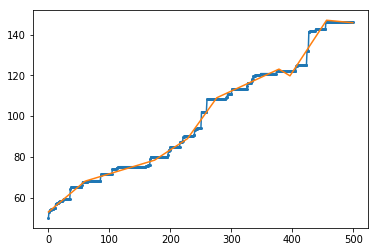

In [134]:
Earthmodel = Earth(smooth=False)

ydata = y_
Earthmodel.fit(datatime, ydata)
y_predict = Earthmodel.predict(datatime)

plt.figure()
plt.plot(datatime, y_, '-o', markersize = 2, label = 'after isotonic regression')
plt.plot(datatime, y_predict, label = 'Earth smoothen')